[link to datasets from the paper](https://figshare.com/search?q=Algorithms+for+seeding+social+networks+can+enhance+the+adoption+of+a+public+health+intervention+in+urban+India.): *Algorithms for seeding social networks can enhance the adoption of a public health intervention in urban India*




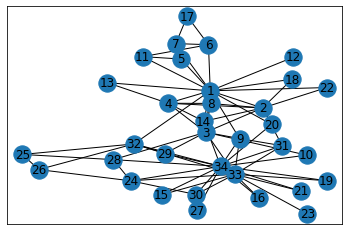

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random

G=nx.read_adjlist("data/karate_edges_77.txt",nodetype=int)
nx.draw_networkx(G,pos=nx.spring_layout(G))


EGOS [node 1, node 2, ...., node n]

ALTER [friend 1, None, ..., friend n]

In [2]:
def get_seeds(g, p, method):
    #NOTE: the proportion p should not be too high. otherwise there'll be lots of nodes with No available alters
    if method not in ['random', 'friend','pair']:
        raise ValueError("invalid input")

    num_seeds = int(p*g.number_of_nodes()) #number of egos
    samp = random.sample(list(g.nodes()), k = num_seeds) #sample egos w/out replacement
    
    if method == "random":
        return samp

    #{node: friend} dict
    friend_dict  = dict.fromkeys(samp) #initialise as {node: None, ...}

    samp_degrees = dict(g.degree(samp))#degrees of the egos

    #consider egos in ascending order of degree. to deal with edge cases 
    # \              
    # -(x)-()-(x) 
    nodes_by_degree = [k for k, v in sorted(samp_degrees.items(), key=lambda item: item[1])]

#     print("node, available friends:")
    for n in nodes_by_degree:
        friends = list(g.adj[n])
        available_f = [f for f in friends
            if f not in list(friend_dict.values())
            and f not in list(friend_dict.keys())] #friends that are not alters or egos
#         print(n,available_f)

        if len(available_f) > 0:
            friend_dict[n] = random.choice(available_f) #randomly assign one of the alters as friend          

#     print("\nresulting seeding:")
#     print(friend_dict) 

    #try to replace egos that don't have alters. 
    # -(x)-(x), sometimes, even going in ascending order not enough. 
    for n in list(friend_dict.keys()):
        if friend_dict[n] is None:
            replacements = [n for n in list(g.nodes()) if 
                n not in (list(friend_dict.values()) + list(friend_dict.keys()))]
#             print("\nreplacements")
#             print(n, replacements)

            random.shuffle(replacements) #shuffle the order
            for r in replacements:
                #SAME AS ABOVE
                friends = list(g.adj[r])
                available_f = [f for f in friends if f not in list(friend_dict.values()) and f not in list(friend_dict.keys())] #friends that are not alters or egos
                
                if len(available_f) > 0:
                    friend_dict[r] = random.choice(available_f) #make new key for replacement
                    friend_dict.pop(n, None) #remove old ego that didn't have alter
#                     print("{} replaced {}".format(r,n))
                    break

            if n in list(friend_dict.keys()): # if n is still in the list
                raise Exception('unable to find replacement for node',n)

#     print("\nfinal dict:")
#     print(friend_dict)

    if method == 'friend':
        return list(friend_dict.values())

    else:#method pair
        half_keys = random.sample(list(friend_dict.keys()), 
                        k = int(len(friend_dict.keys())/2)) #sample half the keys
        half_values = [friend_dict[k] for k in half_keys]#their corresponding values
        return half_keys + half_values
    

In [3]:
seeds = get_seeds(G, 0.2, 'pair')
seeds# the final targeted nodes, by whichever method (random, pair, friend)

[26, 28, 19, 24, 3, 34]

## simulating seeds

In [4]:
#counts of how many times the node got selected as seed. If want mean, sd, use lists. 
random_counts = dict.fromkeys(G.nodes(), 0)
friend_counts = dict.fromkeys(G.nodes(), 0)
pair_counts = dict.fromkeys(G.nodes(), 0)

n_samples = 1000
p = 0.2

for i in range(n_samples):
    random_samp = get_seeds(G, p, 'random')
    friend_samp = get_seeds(G, p, 'friend')
    pair_samp = get_seeds(G, p, 'pair')

    for node in random_samp:
        random_counts[node] += 1
    for node in friend_samp:
        friend_counts[node] += 1
    for node in pair_samp:
        pair_counts[node] += 1


In [5]:
#turn to simulated probabilities
random_probs = {k:v/n_samples for (k,v) in sorted(random_counts.items(), key=lambda item: item[1], reverse = True)}
friend_probs = {k:v/n_samples for (k,v) in sorted(friend_counts.items(), key=lambda item: item[1], reverse = True)}
pair_probs = {k:v/n_samples for (k,v) in sorted(pair_counts.items(), key=lambda item: item[1], reverse = True)}

random_probs

{16: 0.198,
 23: 0.198,
 9: 0.195,
 13: 0.191,
 20: 0.191,
 8: 0.188,
 26: 0.187,
 10: 0.186,
 12: 0.185,
 27: 0.184,
 2: 0.183,
 29: 0.183,
 25: 0.183,
 28: 0.182,
 1: 0.18,
 31: 0.178,
 22: 0.175,
 3: 0.174,
 11: 0.174,
 17: 0.174,
 14: 0.171,
 18: 0.171,
 24: 0.171,
 30: 0.171,
 32: 0.17,
 5: 0.168,
 15: 0.168,
 34: 0.166,
 33: 0.163,
 19: 0.163,
 6: 0.162,
 7: 0.161,
 4: 0.16,
 21: 0.146}

# Calculate Centrality Measures

In [6]:
# Centrality measures
measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
listMeasures = [dict(nx.degree(G)),
                nx.eigenvector_centrality_numpy(G),
                nx.katz_centrality_numpy(G),
                nx.pagerank(G),
                nx.betweenness_centrality(G)]

# Dictionaries sorted in ascending of node number
listMeasures = [dict(sorted(x.items(), key=lambda item: item[0])) for x in listMeasures]

measuresData = pd.DataFrame(listMeasures).T
measuresData.columns = measuresNames

In [7]:
measuresData.head()

Degree  Eigenvector      Katz  Page Rank  Betweeness
1    16.0     0.368734  0.325909   0.097486    0.437646
2     9.0     0.275614  0.238784   0.053198    0.053874
3    10.0     0.324370  0.268555   0.057649    0.152264
4     6.0     0.219781  0.197899   0.036047    0.011962
5     3.0     0.079713  0.124113   0.022035    0.000631

# Spearman and Correlations

In [8]:
# Combining seed data - proportions
seedNames = ["Random", "Friend", "Pair"]
listSeedsProbs = [random_probs, friend_probs, pair_probs]
listSeedsProbs = [dict(sorted(x.items(), key=lambda item: item[0])) for x in listSeedsProbs]

seedDataProbs = pd.DataFrame(listSeedsProbs).T
seedDataProbs.columns = seedNames
seedDataProbs.head()

Random  Friend   Pair
1   0.180   0.661  0.408
2   0.183   0.447  0.319
3   0.174   0.440  0.306
4   0.160   0.267  0.241
5   0.168   0.148  0.170

In [9]:
combinedDataProbs = pd.concat([measuresData, seedDataProbs], axis=1)
combinedDataProbs.head()

Degree  Eigenvector      Katz  Page Rank  Betweeness  Random  Friend   Pair
1    16.0     0.368734  0.325909   0.097486    0.437646   0.180   0.661  0.408
2     9.0     0.275614  0.238784   0.053198    0.053874   0.183   0.447  0.319
3    10.0     0.324370  0.268555   0.057649    0.152264   0.174   0.440  0.306
4     6.0     0.219781  0.197899   0.036047    0.011962   0.160   0.267  0.241
5     3.0     0.079713  0.124113   0.022035    0.000631   0.168   0.148  0.170

In [10]:
meltedDataProbs = pd.melt(combinedDataProbs.reset_index(), id_vars = [*seedNames, "index"], value_name = 'Measure Value', var_name = "Measure")
meltedDataProbs = pd.melt(meltedDataProbs, id_vars = ["index", "Measure", "Measure Value"], value_name = 'Selection Probability', var_name = "Targeting Method")


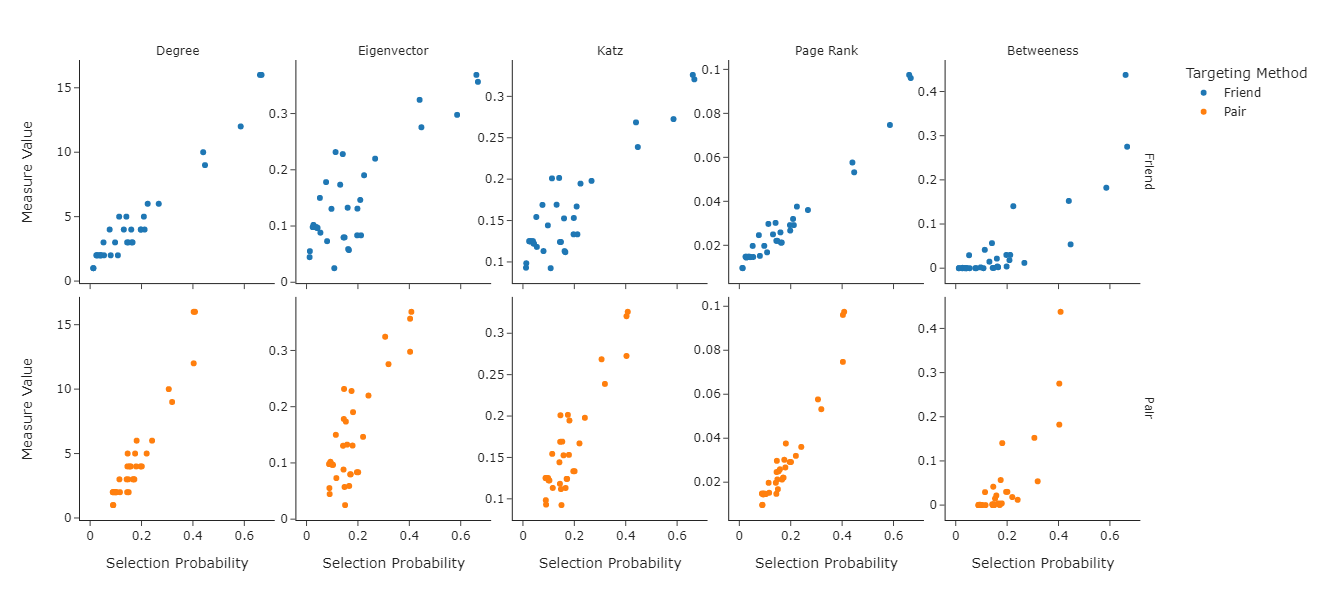

In [11]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyterlab-plotly
import plotly.express as px
import re
fig = px.scatter(meltedDataProbs.query("`Targeting Method` != 'Random'"), 
                 x = "Selection Probability", 
                 y = "Measure Value", 
                 facet_col = "Measure", 
                 facet_row = "Targeting Method", 
                 color = 'Targeting Method',
                 template = "simple_white",
                 facet_col_wrap = 2,
                 width = 1000, 
                 height = 600)

for k in fig.layout:
    if re.search('yaxis[1-9]+', k):
        fig.layout[k].update(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)

fig.show()

In [12]:
# Calculating Spearman Correlation
spearmanData = meltedDataProbs.groupby(['Targeting Method', 'Measure'])[['Selection Probability','Measure Value']].corr(method="spearman").iloc[0::2,-1]
# Dropping level_2 which was artificially created by grouping
spearmanData = spearmanData.reset_index().drop('level_2', axis = 1).query("`Measure Value` != 1")

In [13]:
spearmanData.sort_values("Measure").reset_index().drop("index", axis = 1)

Targeting Method      Measure  Measure Value
0            Friend   Betweeness       0.830156
1              Pair   Betweeness       0.822327
2            Random   Betweeness      -0.226087
3            Friend       Degree       0.901692
4              Pair       Degree       0.901216
5            Random       Degree      -0.311678
6            Friend  Eigenvector       0.525753
7              Pair  Eigenvector       0.535346
8            Random  Eigenvector      -0.159970
9            Friend         Katz       0.646438
10             Pair         Katz       0.663609
11           Random         Katz      -0.263799
12           Friend    Page Rank       0.927119
13             Pair    Page Rank       0.927649
14           Random    Page Rank      -0.364994

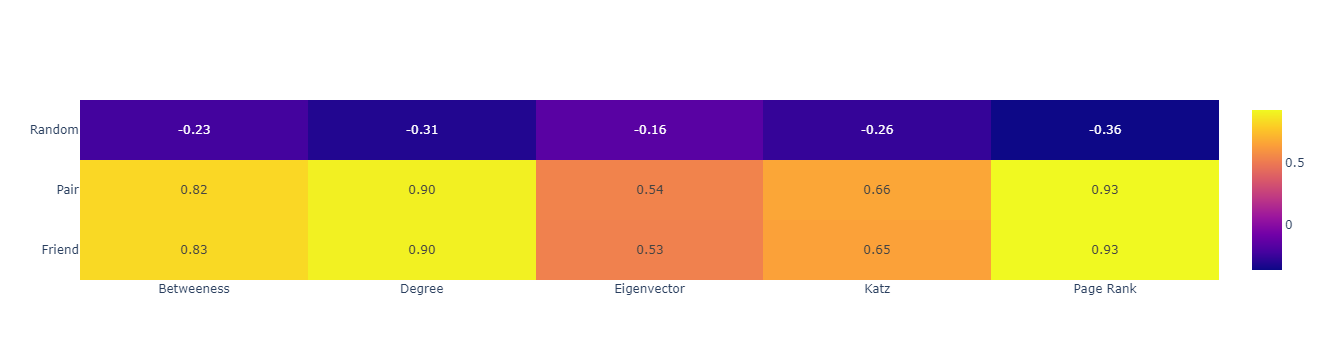

In [14]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = spearmanData.pivot("Targeting Method", "Measure", "Measure Value").columns,
        y = spearmanData.pivot("Targeting Method", "Measure", "Measure Value").index,
        z = np.array(spearmanData.pivot("Targeting Method", "Measure", "Measure Value")),
        text = spearmanData.pivot("Targeting Method", "Measure", "Measure Value").values,
        texttemplate = '%{text:.2f}'
    )
)
fig.show()

In [26]:
meltedDataProbs.to_csv("seedingKarate.csv", index = False)

# Boxplot Comparison

In [15]:
n_samples = 1000
p = 0.2
measuresPerSample = pd.DataFrame([], columns = [*measuresNames, "Method"])

for i in range(n_samples):
    for measure in ["random", "friend", "pair"]:
        summarisedMeasures = pd.DataFrame(measuresData.loc[get_seeds(G, p, measure)].mean()).T
        summarisedMeasures.insert(5, "Method", [measure], True)
        measuresPerSample = measuresPerSample.append(summarisedMeasures)

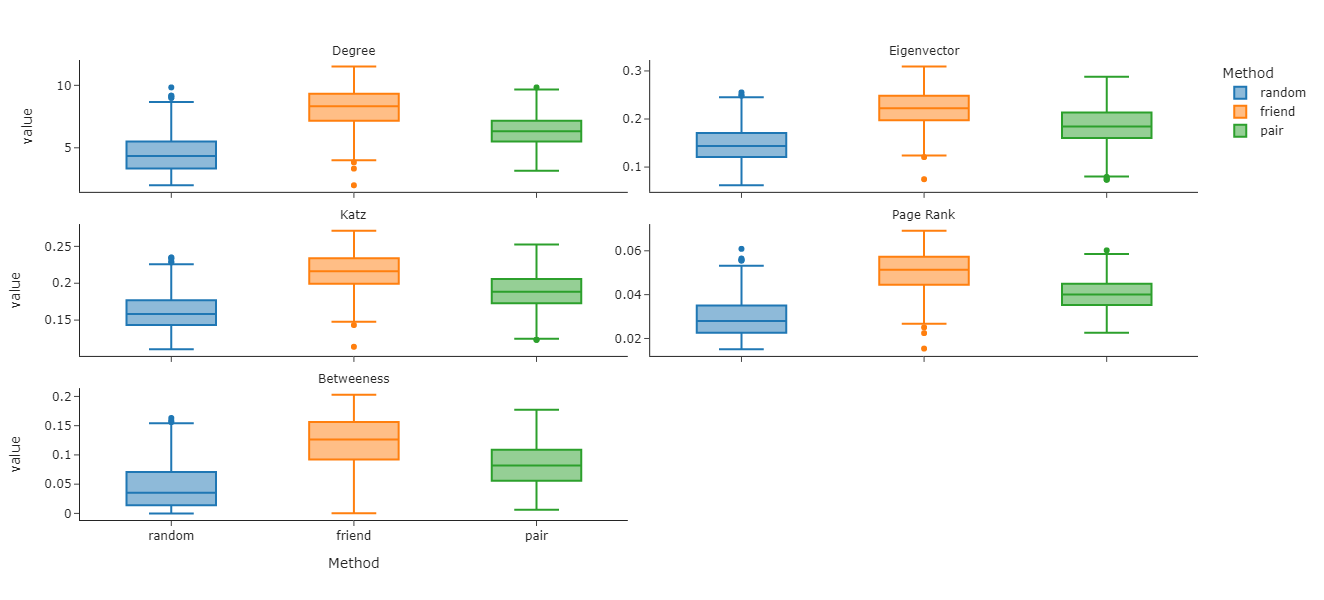

In [16]:


fig = px.box(measuresPerSample.melt(id_vars = "Method"), 
                 x = "Method", 
                 y = "value", 
                 color = 'Method',
                 facet_col = "variable", 
                 template = "simple_white",
                 facet_col_wrap = 2,
                 width = 1000, 
                 height = 600)

for k in fig.layout:
    if re.search('yaxis[1-9]+', k):
        fig.layout[k].update(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)

fig.show()

In [17]:
# Looking at more social networks
# Look at more random graph networks - fit to empirical
# how often we get that pair method triplet scenario
# References from other papers 

In [18]:
#FUNCTIONALISED THE ABOVE
from functions import get_seeds
get_seeds(G, 0.2, "random")

[32, 15, 1, 23, 18, 28]

In [19]:
from functions import get_prob_centralities
probs, centralities = get_prob_centralities(G)

In [20]:
print(probs.head())
print(centralities.head())

   Random  Friend   Pair
1   0.168   0.625  0.380
2   0.197   0.451  0.305
3   0.171   0.409  0.300
4   0.167   0.293  0.221
5   0.179   0.135  0.170
   Degree  Eigenvector      Katz  Page Rank  Betweeness
1    16.0     0.368734  0.325909   0.097486    0.437646
2     9.0     0.275614  0.238784   0.053198    0.053874
3    10.0     0.324370  0.268555   0.057649    0.152264
4     6.0     0.219781  0.197899   0.036047    0.011962
5     3.0     0.079713  0.124113   0.022035    0.000631
